In [1]:
import yaw
import matplotlib.pyplot as plt

In [2]:
ref_path = ('For_YAW/entire_reference_catalog')
rand_path = ('For_YAW/Random_catalog')
real_path = ('For_YAW/real_unknown_catalog')
#fake_unkn_05_1_path = ('For_YAW/fake_unknown_catalog_05_1')
YAW_example_data_path = ('For_YAW/2dflens_kidss_data')
YAW_example_rand_path = ('For_YAW/2dflens_kidss_rand_5x')

In [3]:
ref_path+'.csv'

'For_YAW/entire_reference_catalog.csv'

In [4]:
import pandas as pd

df_ref = pd.read_csv(ref_path+'.csv')
#df_fake_05_1 = pd.read_csv(fake_unkn_05_1_path+'.csv')
df_rand = pd.read_csv(rand_path+'.csv')
df_real = pd.read_csv(real_path+'.csv')

df_YAW_data = pd.read_parquet(YAW_example_data_path+'.pqt')
df_YAW_rand = pd.read_parquet(YAW_example_rand_path+'.pqt')

df_ref = df_ref.rename(columns={'redshift': 'redshifts'})


df_YAW_data = df_YAW_data.rename(columns={'RA': 'ra',
                                          'Dec': 'dec',
                                          'redshift': 'redshifts'})

df_YAW_rand = df_YAW_rand.rename(columns={'RA': 'ra',
                                          'Dec': 'dec',
                                          'redshift': 'redshifts'})

df_YAW_unkn = df_YAW_data[(df_YAW_data['redshifts'] >= 0.3) & (df_YAW_data['redshifts'] < 0.5)].sample(n = 1000, random_state=42)
df_Web_unkn = df_ref[(df_ref['redshifts'] >= 1.2) & (df_ref['redshifts'] < 1.7)].sample(n = 1000, random_state=42)

In [5]:
import astropy.units as u
from astropy.coordinates import SkyCoord

df_rand = pd.read_csv(rand_path+'.csv')
df_Cos_3D = pd.read_csv('For_YAW/C3D_Candidates_v2_Christa_F115W.csv')

In [6]:
import Koki_help.HSC_toolkits as HSC
hsc = HSC.HSC_toolkits()

In [7]:
import pickle
with open("For_YAW/ref_galaxy_bins.pkl", "rb") as f:
    ref_galaxy_bins = pickle.load(f)

In [8]:
random = {}
random['SkyCoord'] = SkyCoord(df_rand['ra'], df_rand['dec'], unit=(u.deg, u.deg), frame='icrs')
reference_bins = {}
for key in ref_galaxy_bins:
    reference_bins[key] = {'SkyCoord': SkyCoord(ref_galaxy_bins[key]['ra'], ref_galaxy_bins[key]['dec'], unit=(u.deg, u.deg), frame='icrs')}

cosmos_web = {}
cosmos_web['SkyCoord'] = SkyCoord(df_Web_unkn['ra'], df_Web_unkn['dec'], unit=(u.deg, u.deg), frame='icrs')

cosmos_3D = {}
cosmos_3D['SkyCoord'] = SkyCoord(df_Cos_3D['RA'], df_Cos_3D['Dec'], unit=(u.deg, u.deg), frame='icrs')


In [9]:
bins=10
min_bin=10**-4*u.deg #1*u.arcmin
max_bin=10**-1*u.deg
bin_type='log-bin'
z_bins= ['0.0-1.0', '1.0-2.0' , '2.0-3.0', '3.0-4.0', '4.0-5.0', '5.0-6.0']

for z in z_bins:
    print(len(reference_bins[z]['SkyCoord']))

356999
212748
97776
45042
45060
6844


In [10]:
import numpy as np

def downsample(coords, max_n=50000, seed=42):
    rng = np.random.default_rng(seed)
    if len(coords) > max_n:
        idx = rng.choice(len(coords), size=max_n, replace=False)
        return coords[idx]
    return coords


ref_bins_small = {}
for z in z_bins:
    ref_bins_small[z] = {}
    if len(reference_bins[z]['SkyCoord']) > 100000:
        #print(len(reference_bins[z]['SkyCoord']))
        ref_bins_small[z]['SkyCoord'] = downsample(reference_bins[z]['SkyCoord'], 100000)
        
    if 100000 > len(reference_bins[z]['SkyCoord']) > 50000:
        ref_bins_small[z]['SkyCoord'] = downsample(reference_bins[z]['SkyCoord'])

    if len(reference_bins[z]['SkyCoord']) <= 50000:
        ref_bins_small[z]['SkyCoord'] = reference_bins[z]['SkyCoord']

for z in z_bins:
    print(len(ref_bins_small[z]['SkyCoord']))


100000
100000
50000
45042
45060
6844


In [11]:


Omega_Web={'ACF_LS': [], 'CCF_LS': {}, 'CCF_DP': {}}
Error_Web={'ACF_LS': [], 'CCF_LS': {}, 'CCF_DP': {}}
theta_Web={'ACF_LS': [], 'CCF_LS': {}, 'CCF_DP': {}}

Omega_Web['ACF_LS'], Error_Web['ACF_LS'], theta_Web['ACF_LS']= \
        hsc.Landy_Szalay_estimator(cosmos_web['SkyCoord'],random['SkyCoord'],    #cosmos_Web['SkyCoord']
                                   min_bin=min_bin, max_bin=max_bin,
                                   bins=bins, type=bin_type)




Omega_3D={'ACF_LS': [], 'CCF_LS': {}, 'CCF_DP': {}}
Error_3D={'ACF_LS': [], 'CCF_LS': {}, 'CCF_DP': {}}
theta_3D={'ACF_LS': [], 'CCF_LS': {}, 'CCF_DP': {}}

Omega_3D['ACF_LS'], Error_3D['ACF_LS'], theta_3D['ACF_LS']= \
        hsc.Landy_Szalay_estimator(cosmos_3D['SkyCoord'],random['SkyCoord'],    #cosmos_3D['SkyCoord']
                                   min_bin=min_bin, max_bin=max_bin,
                                   bins=bins, type=bin_type)

Omega_ref={'ACF_LS': {}}
Error_ref={'ACF_LS': {}}
theta_ref={'ACF_LS': {}}

for z in z_bins:
        Omega_ref['ACF_LS'][z], Error_ref['ACF_LS'][z], theta_ref['ACF_LS'][z]= \
                hsc.Landy_Szalay_estimator(ref_bins_small[z]['SkyCoord'],random['SkyCoord'],    #cosmos_3D['SkyCoord']
                                        min_bin=min_bin, max_bin=max_bin,
                                        bins=bins, type=bin_type)

# Omega['CCF'], Error['CCF'], theta['CCF']= \
#         hsc.Landy_Szalay_estimator_cross(
# #                                fg_data_objects, bg_data_objects,
#                                 small_ref['SkyCoord'],reference_bins['0.0-1.0']['SkyCoord'],
#                                 random['SkyCoord'], random['SkyCoord'],
#                                 min_bin=min_bin, max_bin=max_bin,
#                                 bins=bins, type=bin_type)

c:\Users\andre\MasterCode\Code\Koki_help\HSC_toolkits.py:972: RuntimeWarning: divide by zero encountered in divide
  ERROR = 1 / np.sqrt(DD)  #  DD.clip(min=1) avoid div-by-zero


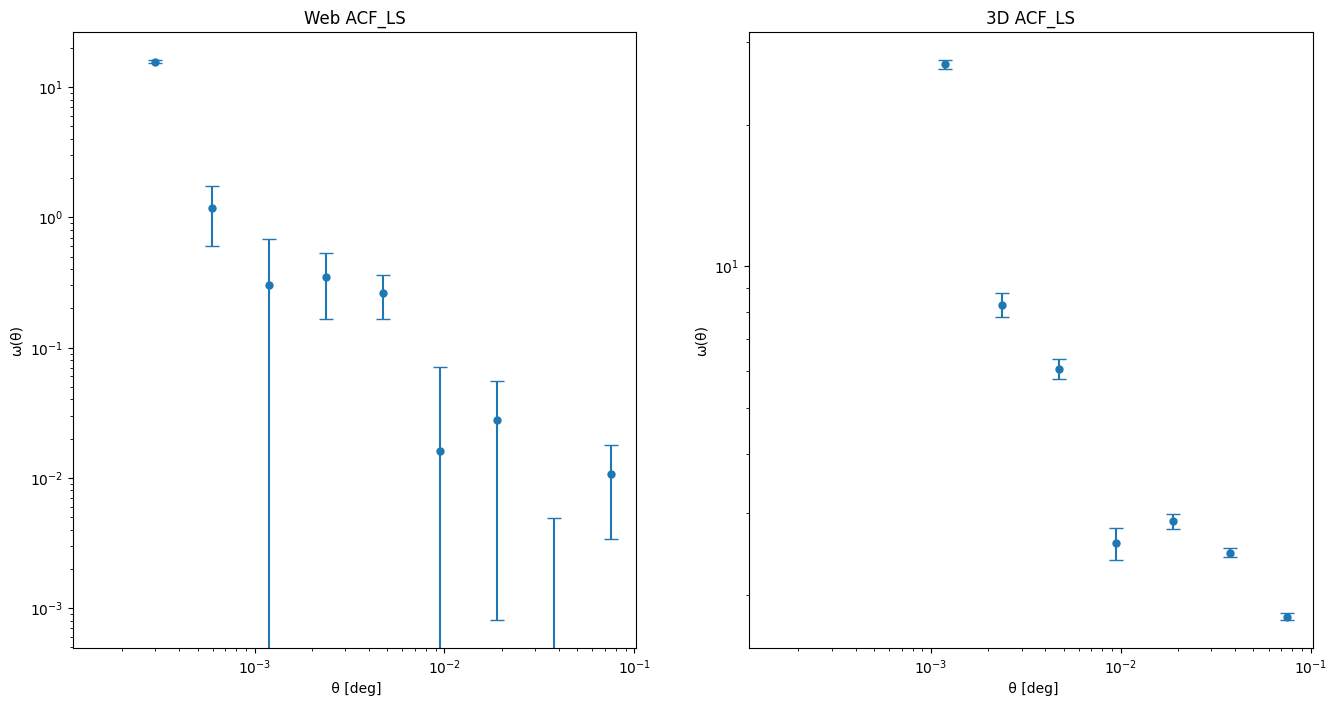

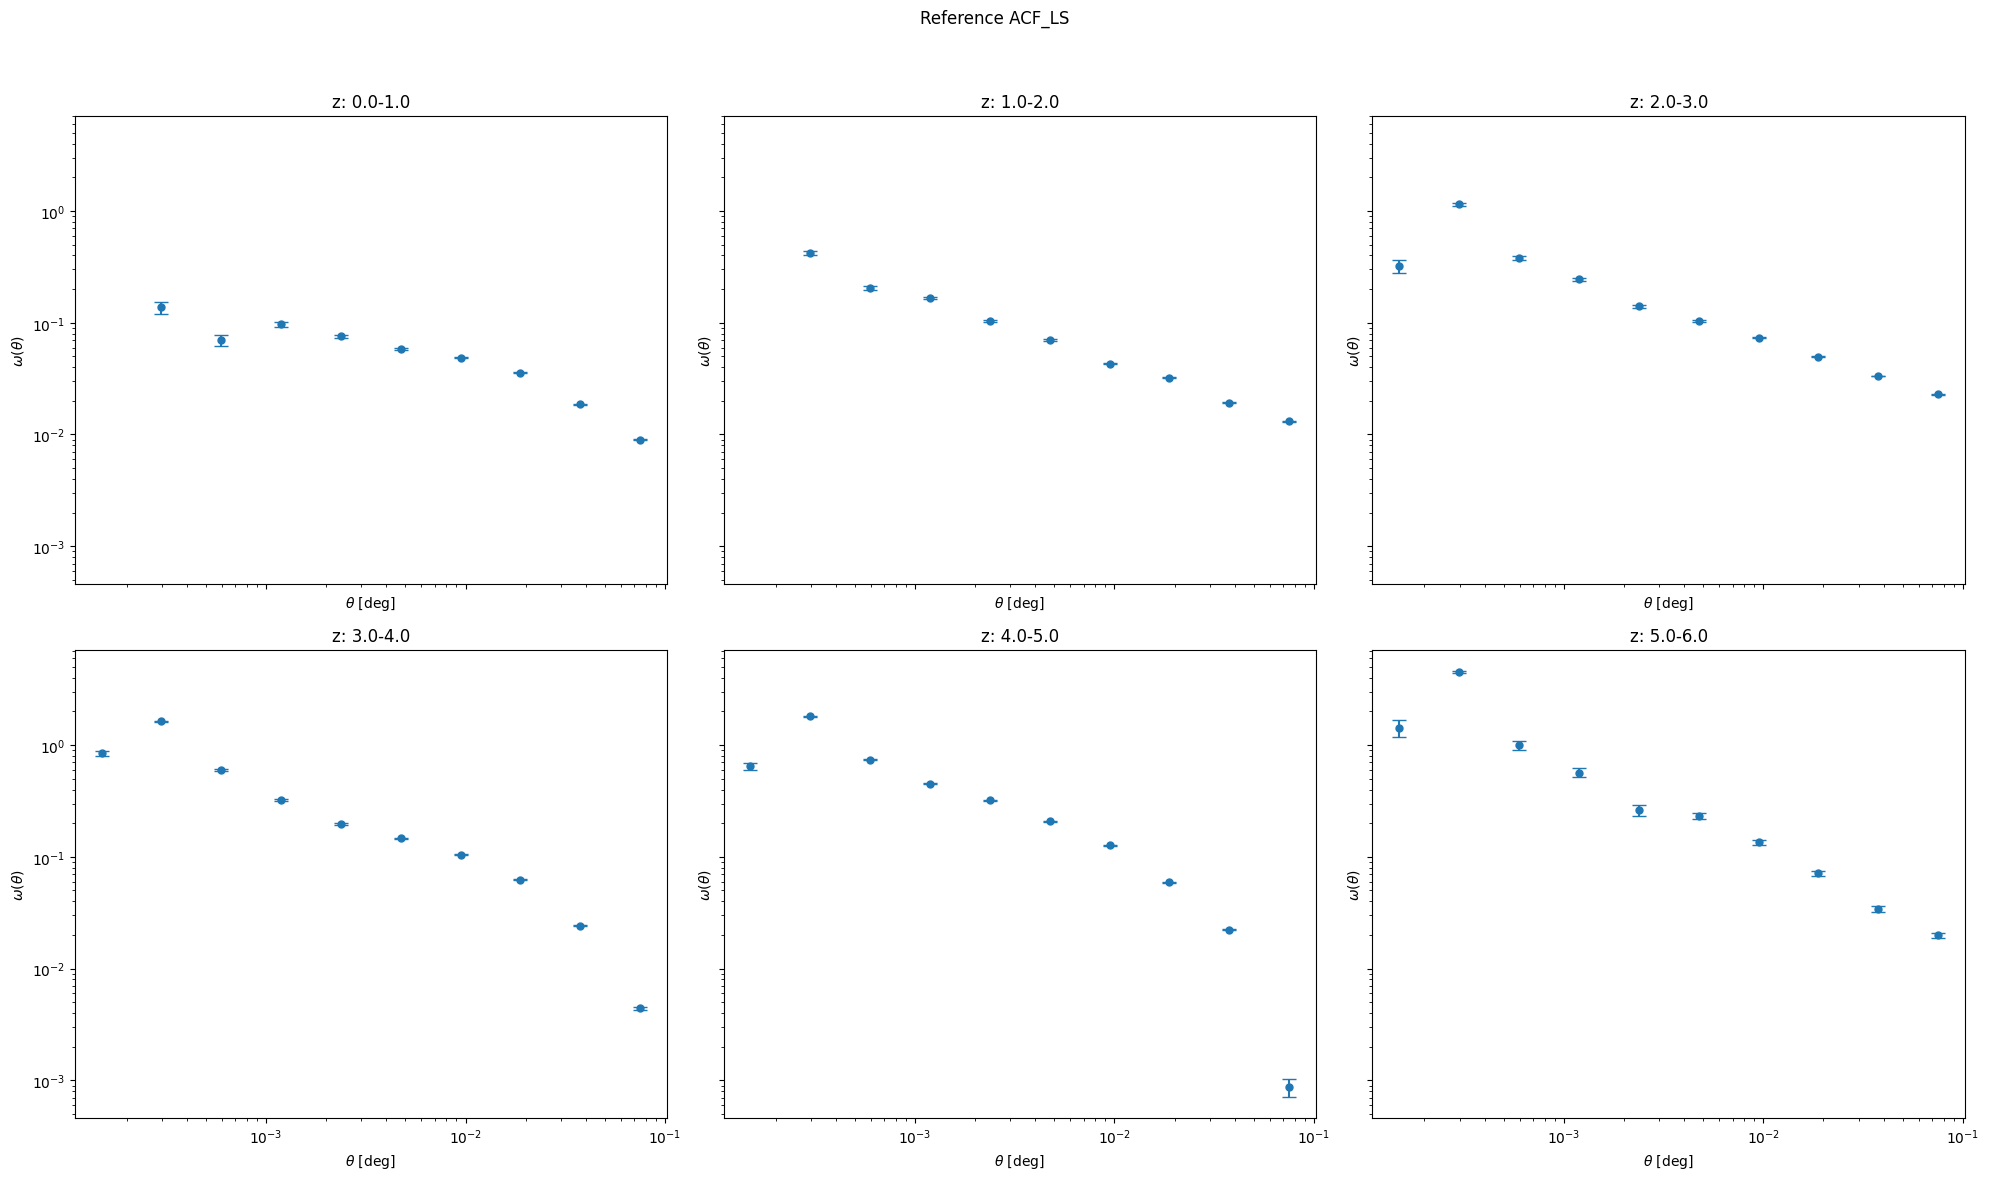

In [12]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.title('Web ACF_LS')
plt.errorbar(theta_Web['ACF_LS'].to('deg').value,Omega_Web['ACF_LS'], yerr = Error_Web['ACF_LS'], fmt='.', ms=10, capsize=5)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('\u03C9(\u03B8)')
plt.xlabel(' \u03B8 [deg]')

plt.subplot(1,2,2)
plt.title('3D ACF_LS')
plt.errorbar(theta_3D['ACF_LS'].to('deg').value,Omega_3D['ACF_LS'], yerr = Error_3D['ACF_LS'], fmt='.', ms=10, capsize=5)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('\u03C9(\u03B8)')
plt.xlabel(' \u03B8 [deg]')
#plt.plot(theta['ACF'].to('arcsec').value,Omega['ACF']+1/N_LAE,yerr=sqrt(Var_JK['ACF']),fmt='s',ms=10,capsize=5)


fig, axes = plt.subplots(2, 3, figsize=(20, 12), sharey=True, sharex=True)
fig.suptitle('Reference ACF_LS')

# Flatten axes array for easier iteration
axes = axes.ravel()

for ax, zbin in zip(axes, z_bins):
    ax.set_title(f'z: {zbin}')
    ax.errorbar(
        theta_ref['ACF_LS'][zbin].to('deg').value,
        Omega_ref['ACF_LS'][zbin],
        yerr=Error_ref['ACF_LS'][zbin],
        fmt='.', ms=10, capsize=5
    )
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\theta$ [deg]')
    ax.set_ylabel(r'$\omega(\theta)$')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [13]:

for z in z_bins:
    Omega_Web['CCF_LS'][z], Error_Web['CCF_LS'][z], theta_Web['CCF_LS'][z] = \
        hsc.Landy_Szalay_estimator_cross(
                                cosmos_web['SkyCoord'], reference_bins[z]['SkyCoord'],    #small_ref['SkyCoord']cosmos_Web['SkyCoord']
                                random['SkyCoord'], random['SkyCoord'],
                                min_bin=min_bin, max_bin=max_bin,
                                bins=bins, type=bin_type)
    

    Omega_3D['CCF_LS'][z], Error_3D['CCF_LS'][z], theta_3D['CCF_LS'][z] = \
        hsc.Landy_Szalay_estimator_cross(
                                cosmos_3D['SkyCoord'], reference_bins[z]['SkyCoord'],    #small_ref['SkyCoord']cosmos_3D['SkyCoord']
                                random['SkyCoord'], random['SkyCoord'],
                                min_bin=min_bin, max_bin=max_bin,
                                bins=bins, type=bin_type)

Computing data1-data2 pair counts ... ...

c:\Users\andre\MasterCode\Code\Koki_help\HSC_toolkits.py:1072: RuntimeWarning: divide by zero encountered in divide
  ERROR = 1 / np.sqrt(D1D2 * N_data_1 * N_data_2)


Computing random1-random2 pair counts ...

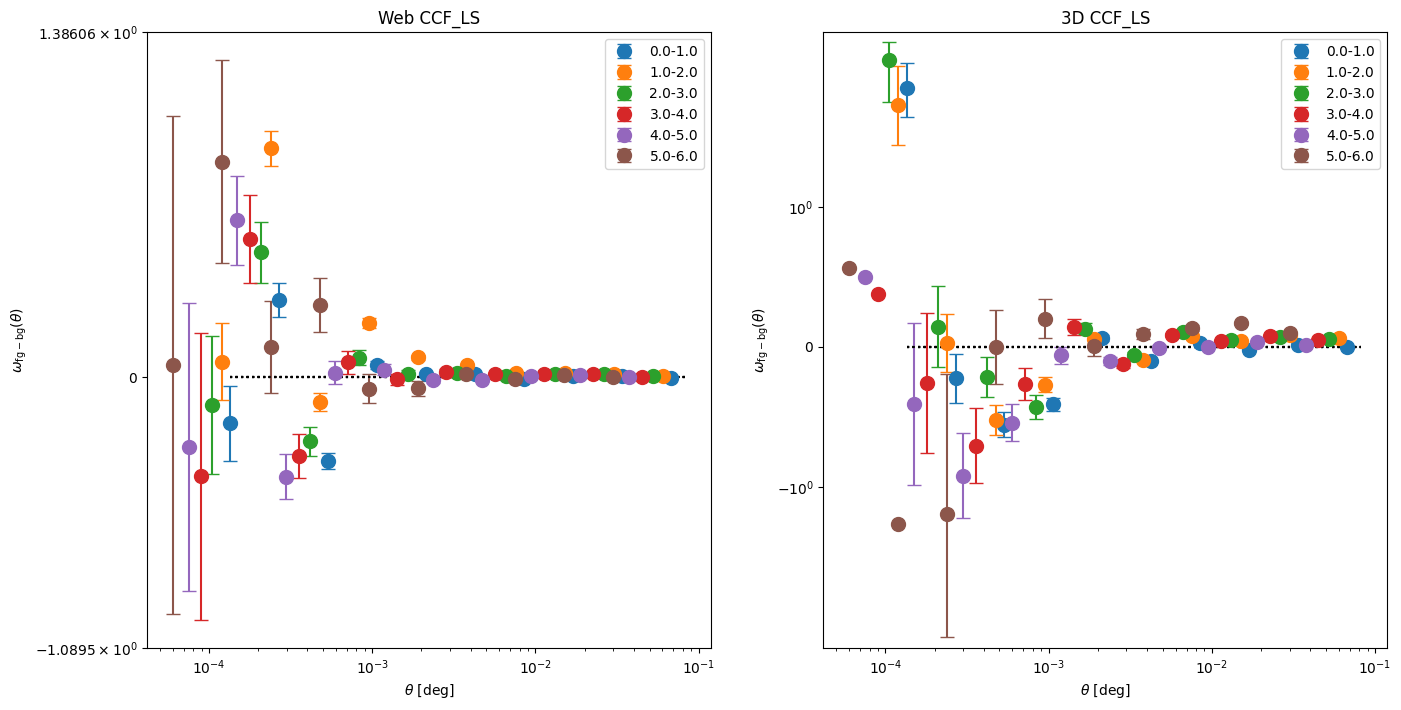

In [14]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.title('Web CCF_LS')
sep = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4]
for i in range(len(z_bins)):
    z=z_bins[i]
    plt.errorbar(theta_Web['CCF_LS'][z].to('deg').value*sep[i], Omega_Web['CCF_LS'][z],
            yerr=Error_Web['CCF_LS'][z], fmt='o', ms=10,capsize=5, label=z)

    
    plt.hlines(0.0, 0.9*theta_Web['CCF_LS'][z].min().to('deg').value,
                1.1*theta_Web['CCF_LS'][z].max().to('deg').value,
                linestyle='dotted',color='black')
plt.xscale('log')
plt.yscale('symlog')
plt.xlabel('$\\theta$ [deg]')
plt.ylabel('$\\omega_{\\rm fg-bg}(\\theta)$')
plt.legend()

plt.subplot(1,2,2)
plt.title('3D CCF_LS')
for i in range(len(z_bins)):
    z=z_bins[i]
    plt.errorbar(theta_3D['CCF_LS'][z].to('deg').value*sep[i], Omega_3D['CCF_LS'][z],
            yerr=Error_3D['CCF_LS'][z], fmt='o', ms=10,capsize=5, label=z)

    
    plt.hlines(0.0, 0.9*theta_3D['CCF_LS'][z].min().to('deg').value,
                1.1*theta_3D['CCF_LS'][z].max().to('deg').value,
                linestyle='dotted',color='black')
plt.xscale('log')
plt.yscale('symlog')
plt.xlabel('$\\theta$ [deg]')
plt.ylabel('$\\omega_{\\rm fg-bg}(\\theta)$')
plt.legend()

In [15]:
z_bins= ['0.0-1.0', '1.0-2.0' , '2.0-3.0', '3.0-4.0', '4.0-5.0', '5.0-6.0']
for z in z_bins:
    Omega_Web['CCF_DP'][z], Error_Web['CCF_DP'][z], theta_Web['CCF_DP'][z] = \
        hsc.Davis_Peebles_estimator_cross(                                                  #, Error_Web['CCF_DP'][z]
                                cosmos_web['SkyCoord'], reference_bins[z]['SkyCoord'],    #small_ref['SkyCoord']cosmos_Web['SkyCoord']
                                random['SkyCoord'],
                                min_bin=min_bin, max_bin=max_bin,
                                bins=bins, type=bin_type)
    
for z in z_bins:
    Omega_3D['CCF_DP'][z], Error_3D['CCF_DP'][z], theta_3D['CCF_DP'][z] = \
        hsc.Davis_Peebles_estimator_cross(                                                  #, Error_3D['CCF_DP'][z]                      
                                cosmos_3D['SkyCoord'], reference_bins[z]['SkyCoord'],    #small_ref['SkyCoord']cosmos_3D['SkyCoord']
                                random['SkyCoord'],
                                min_bin=min_bin, max_bin=max_bin,
                                bins=bins, type=bin_type)

Computing data2 – random1 pair counts ...

c:\Users\andre\MasterCode\Code\Koki_help\HSC_toolkits.py:1152: RuntimeWarning: divide by zero encountered in divide
  ERROR = 1 / np.sqrt(D1D2 * N_data_1 * N_data_2)


Computing data2 – random1 pair counts ...

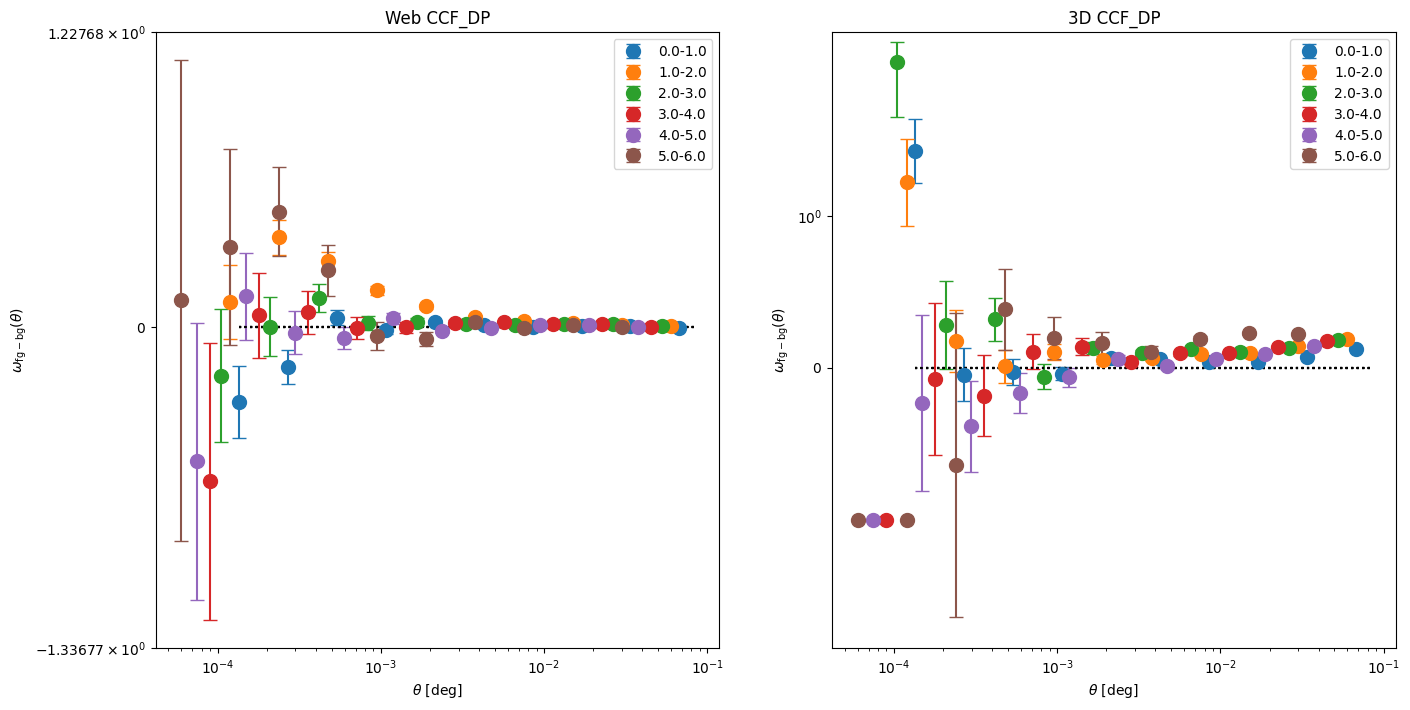

In [16]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.title('Web CCF_DP')
sep = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4]
for i in range(len(z_bins)):
    z=z_bins[i]
    plt.errorbar(theta_Web['CCF_DP'][z].to('deg').value*sep[i], Omega_Web['CCF_DP'][z],
            yerr=Error_Web['CCF_DP'][z], fmt='o', ms=10,capsize=5, label=z)

    plt.hlines(0.0, 0.9*theta_Web['CCF_DP'][z].min().to('deg').value,
                1.1*theta_Web['CCF_DP'][z].max().to('deg').value,
                linestyle='dotted',color='black')
plt.xscale('log')
plt.yscale('symlog')
plt.xlabel('$\\theta$ [deg]')
plt.ylabel('$\\omega_{\\rm fg-bg}(\\theta)$')
plt.legend()

plt.subplot(1,2,2)
plt.title('3D CCF_DP')
for i in range(len(z_bins)):
    z=z_bins[i]
    plt.errorbar(theta_3D['CCF_DP'][z].to('deg').value*sep[i], Omega_3D['CCF_DP'][z],
            yerr=Error_3D['CCF_DP'][z], fmt='o', ms=10,capsize=5, label=z)
    
    plt.hlines(0.0, 0.9*theta_3D['CCF_DP'][z].min().to('deg').value,
                1.1*theta_3D['CCF_DP'][z].max().to('deg').value,
                linestyle='dotted',color='black')
plt.xscale('log')
plt.yscale('symlog')
plt.xlabel('$\\theta$ [deg]')
plt.ylabel('$\\omega_{\\rm fg-bg}(\\theta)$')
plt.legend()

In [17]:
Omega_Web['CCF_DP']['2.0-3.0']

array([-0.20245399,  0.00151745,  0.11985019,  0.01678839,  0.02115435,
        0.01184783,  0.01027691,  0.01252842,  0.01259676,  0.00406278])

In [18]:
angles = theta_Web['CCF_DP']['0.0-1.0'].to('deg').value

In [19]:
def extract_values_errors(Omega, Error, z_bins, angles):
    values_DP, values_LS = [], []
    errors_DP, errors_LS = [], []
    for angle in range(len(angles)):
        value_DP, value_LS = [], []
        error_DP, error_LS = [], []
        for z in z_bins:
            value_DP.append(Omega['CCF_DP'][z][angle])
            value_LS.append(Omega['CCF_LS'][z][angle])
            error_DP.append(Error['CCF_DP'][z][angle])
            error_LS.append(Error['CCF_LS'][z][angle])
            
        values_DP.append(value_DP)
        values_LS.append(value_DP)
        errors_DP.append(error_DP)
        errors_LS.append(error_DP)
    return values_DP, values_LS, errors_DP, errors_LS

values_web_DP, values_web_LS, errors_web_DP, errors_web_LS = extract_values_errors(
    Omega_Web, Error_Web, z_bins, angles
)

values_3D_DP, values_3D_LS, errors_3D_DP, errors_3D_LS = extract_values_errors(
    Omega_3D, Error_3D, z_bins, angles
)


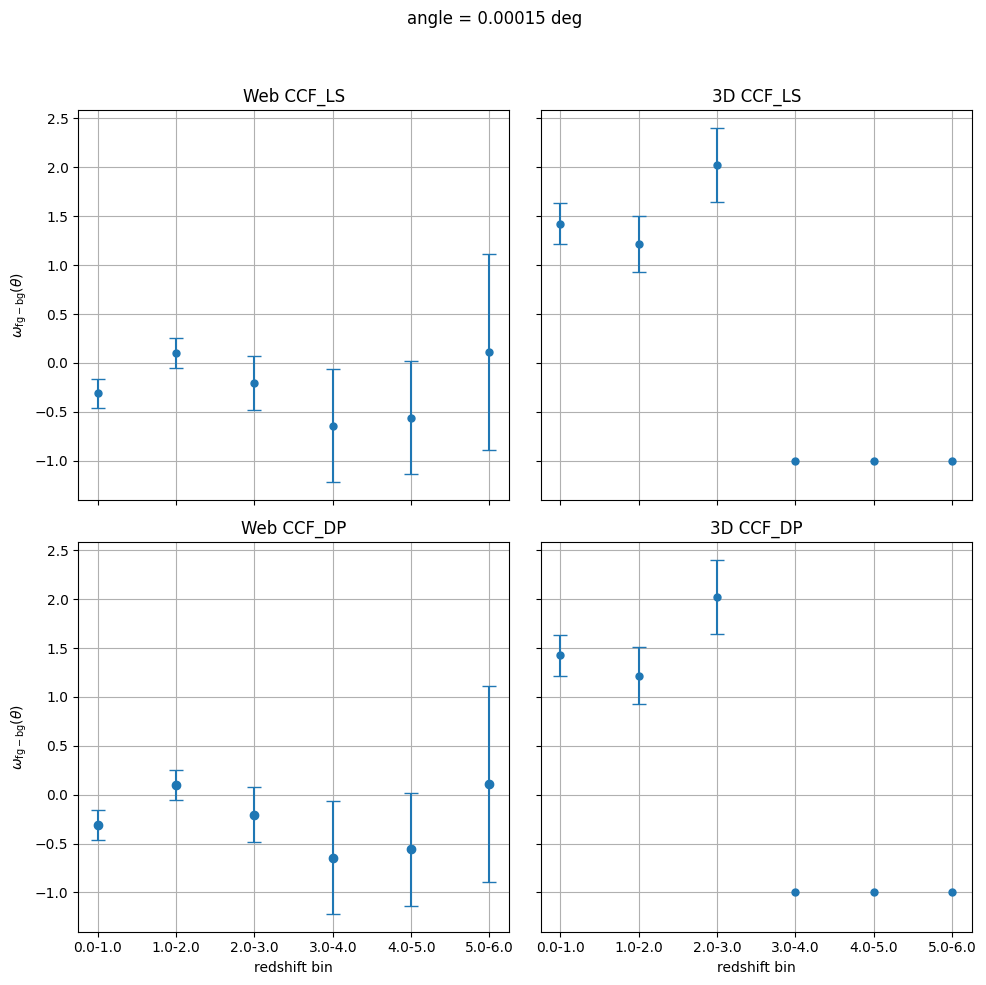

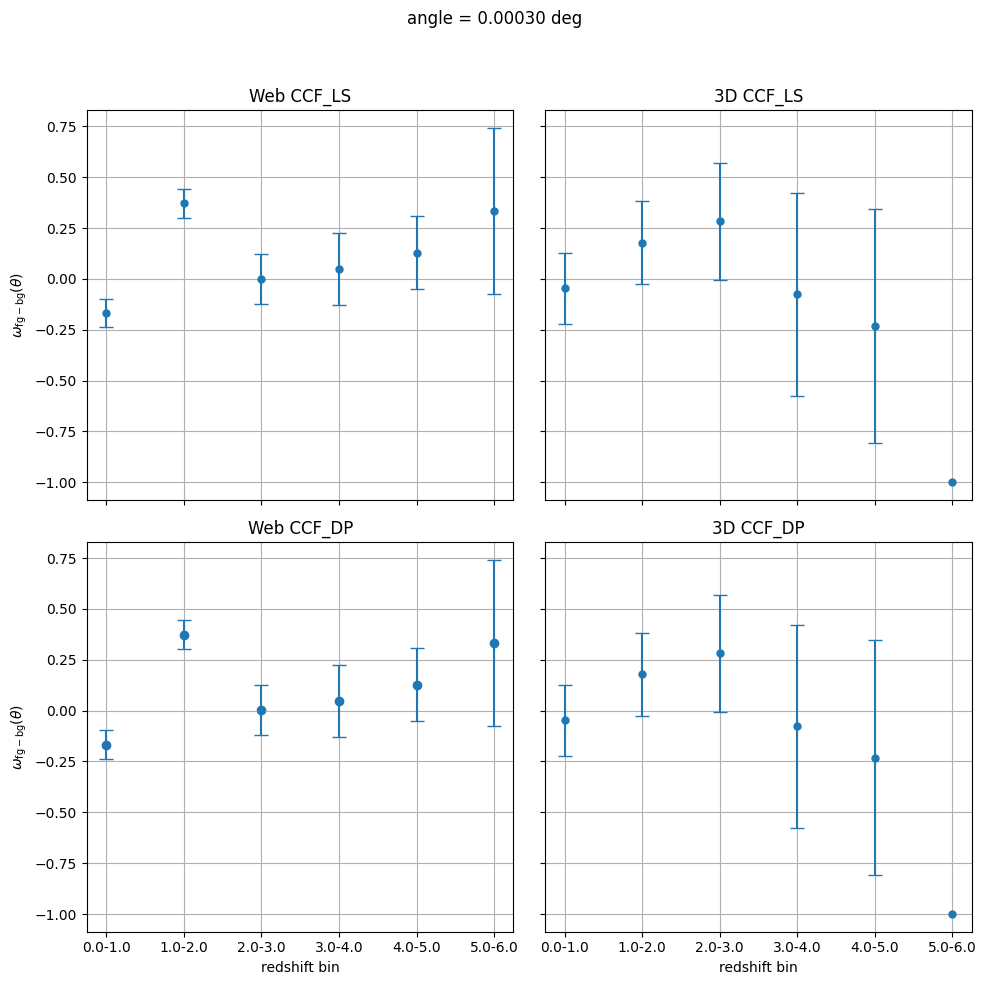

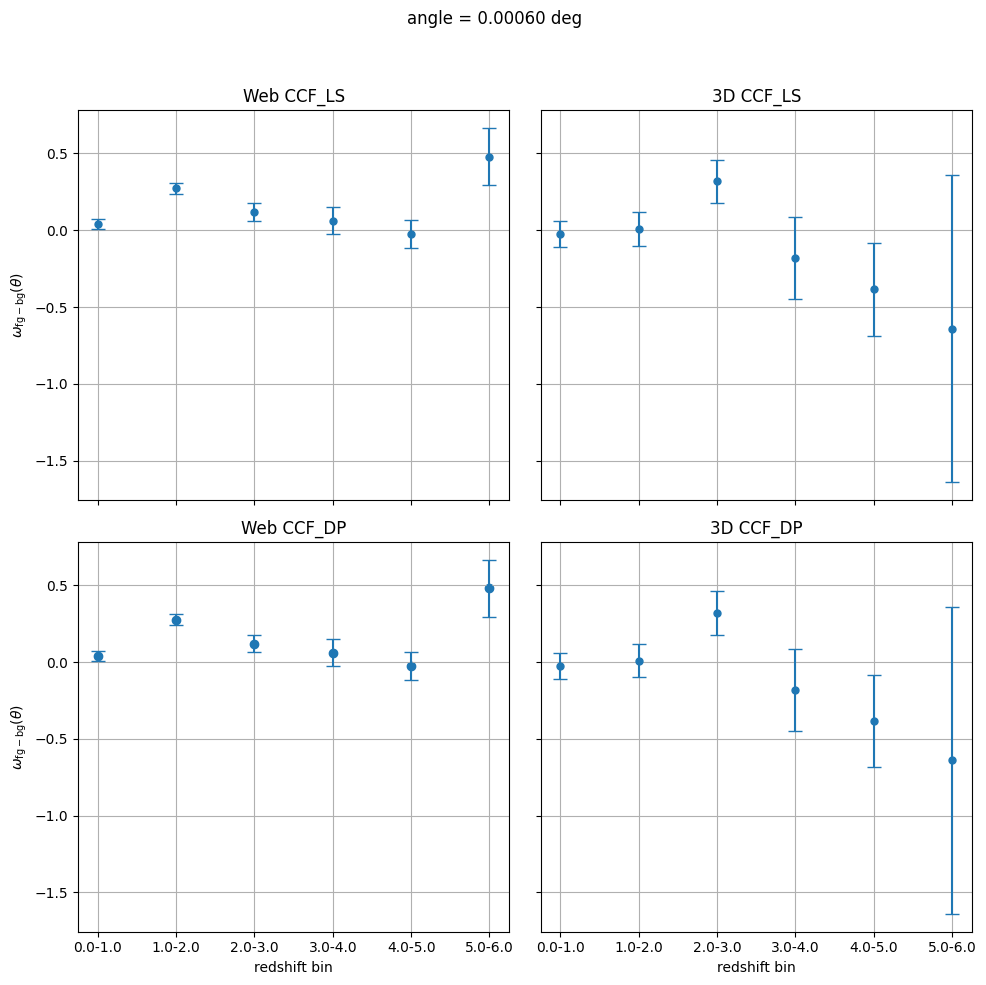

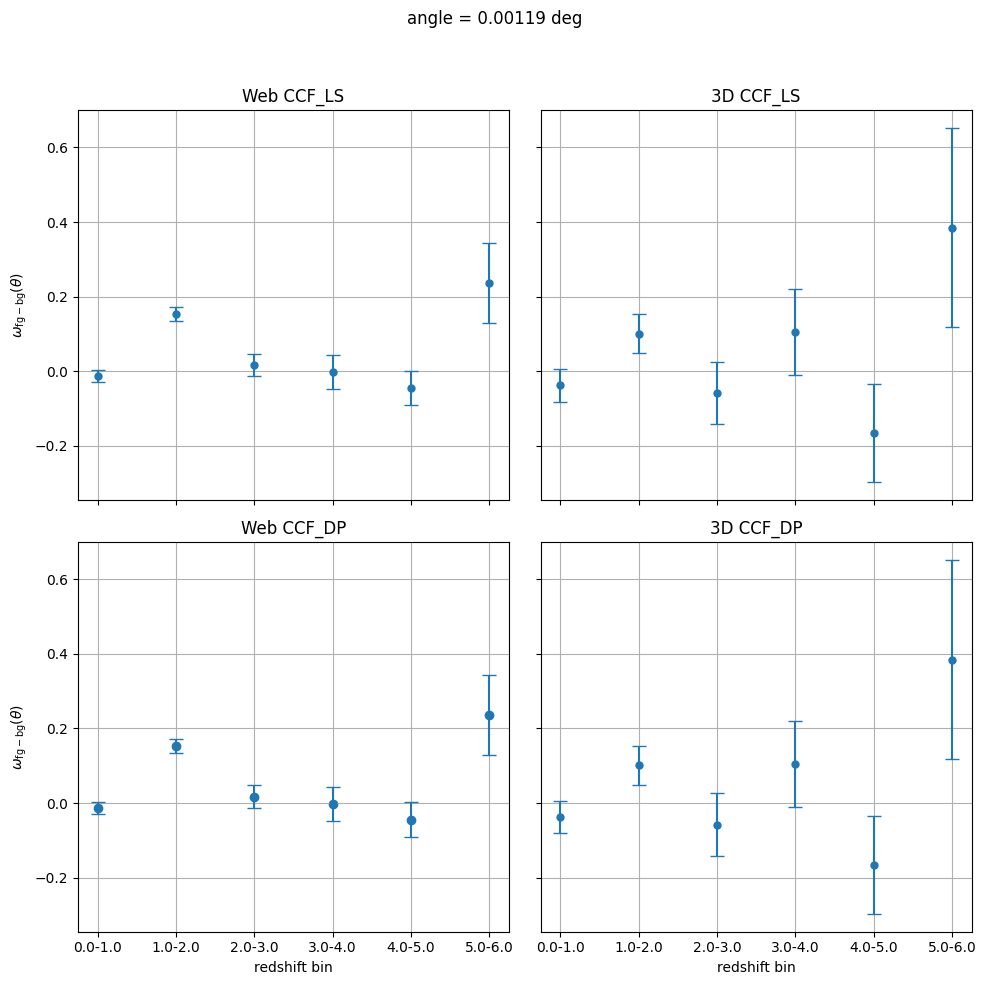

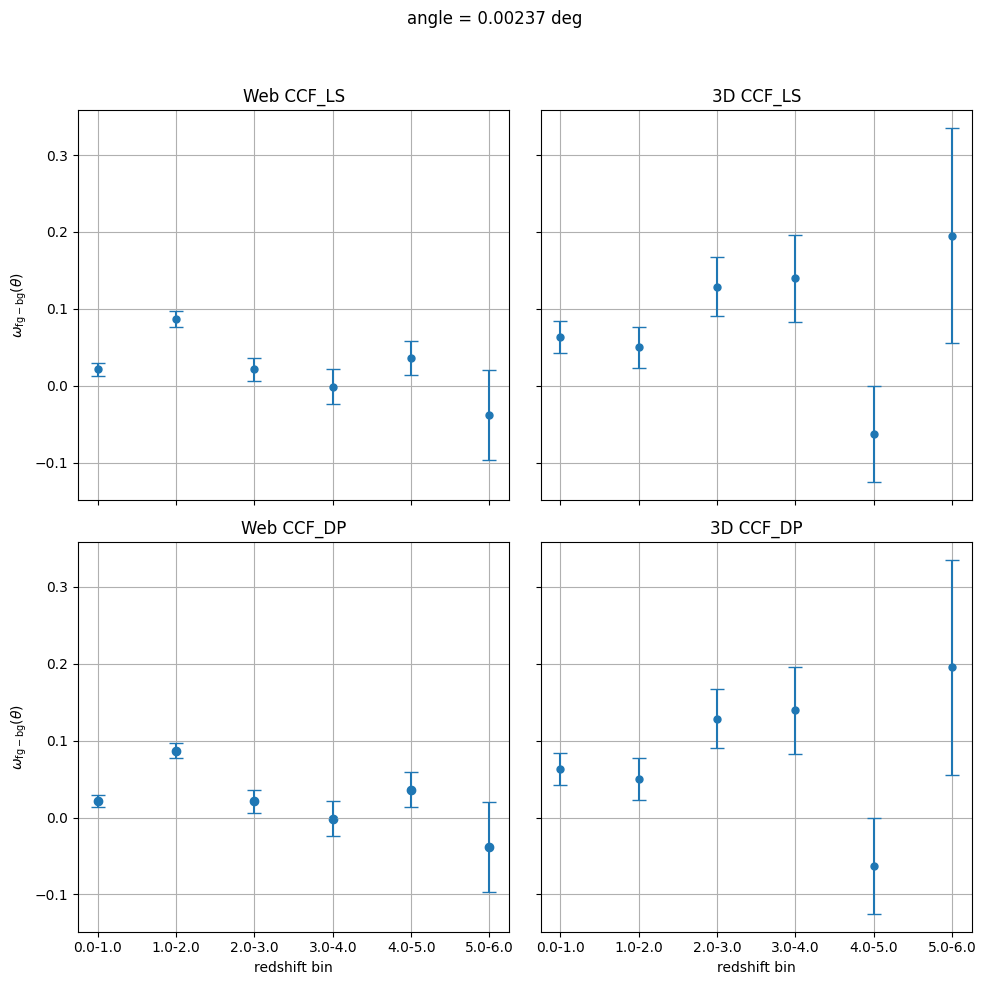

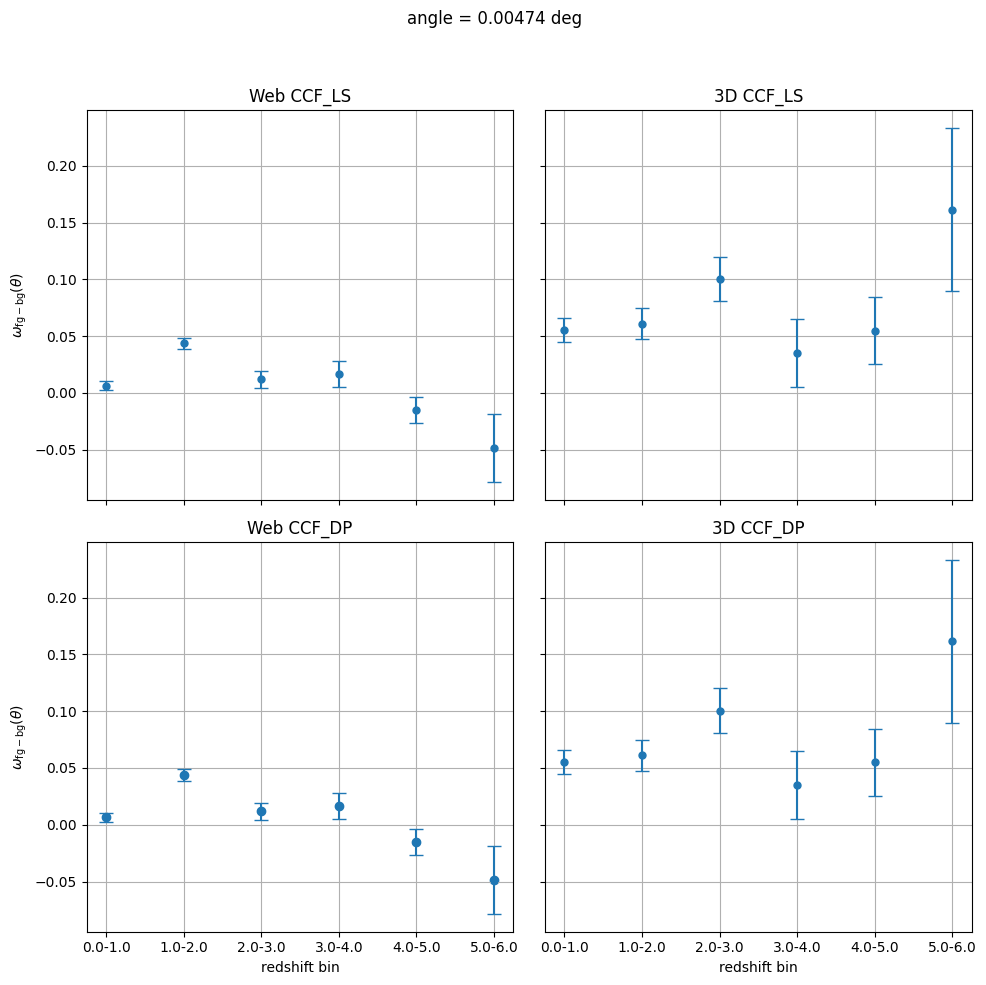

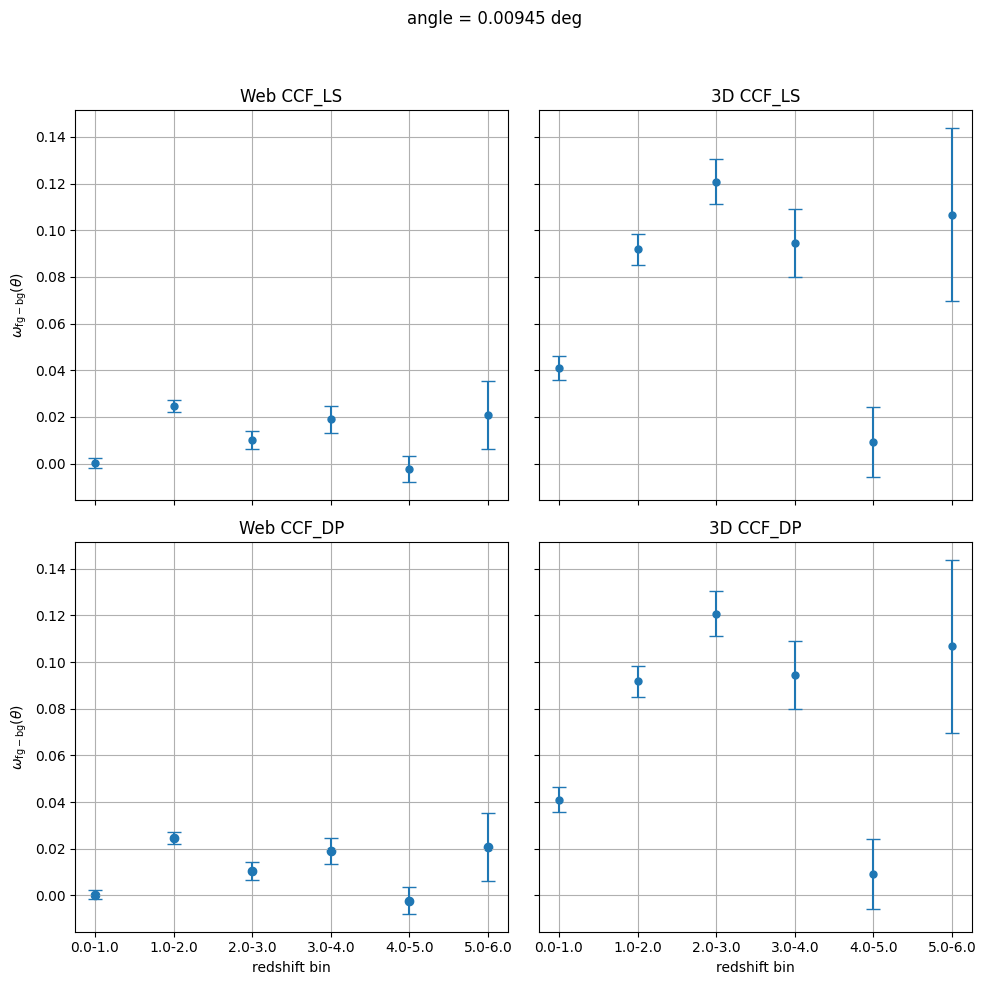

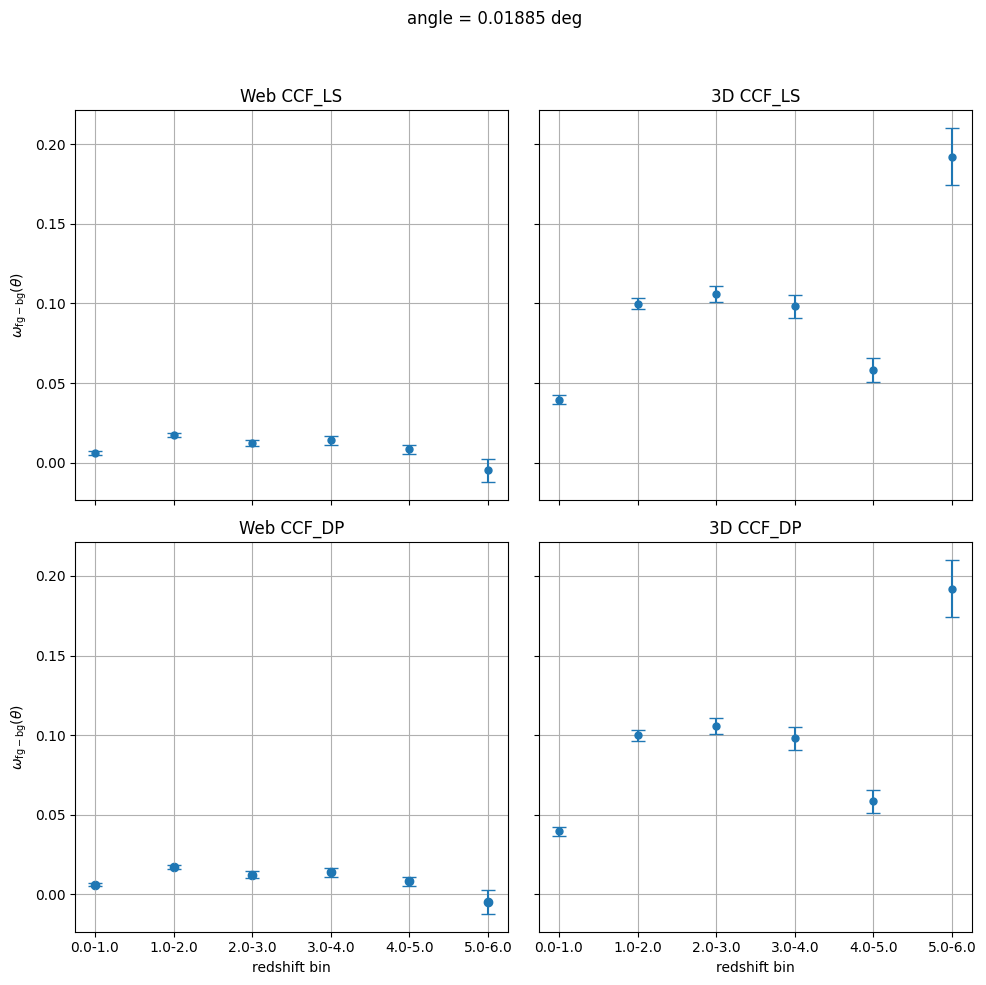

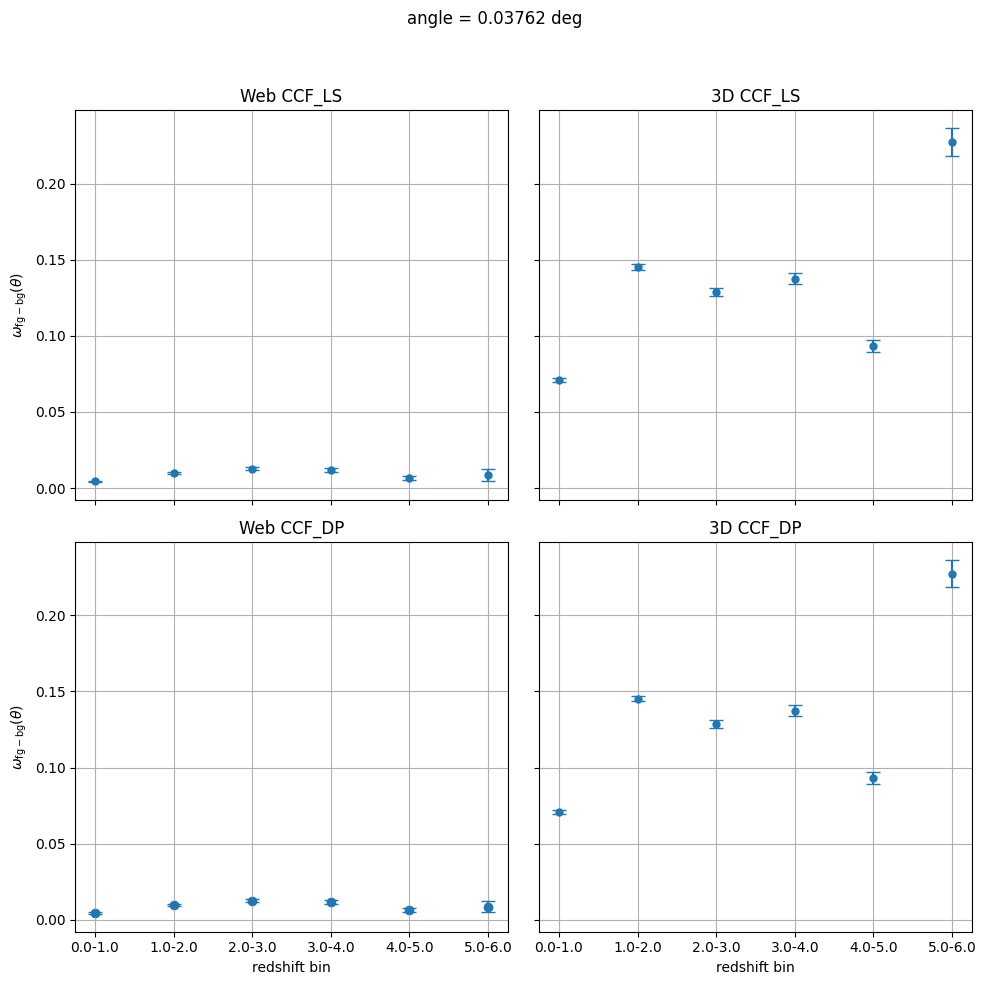

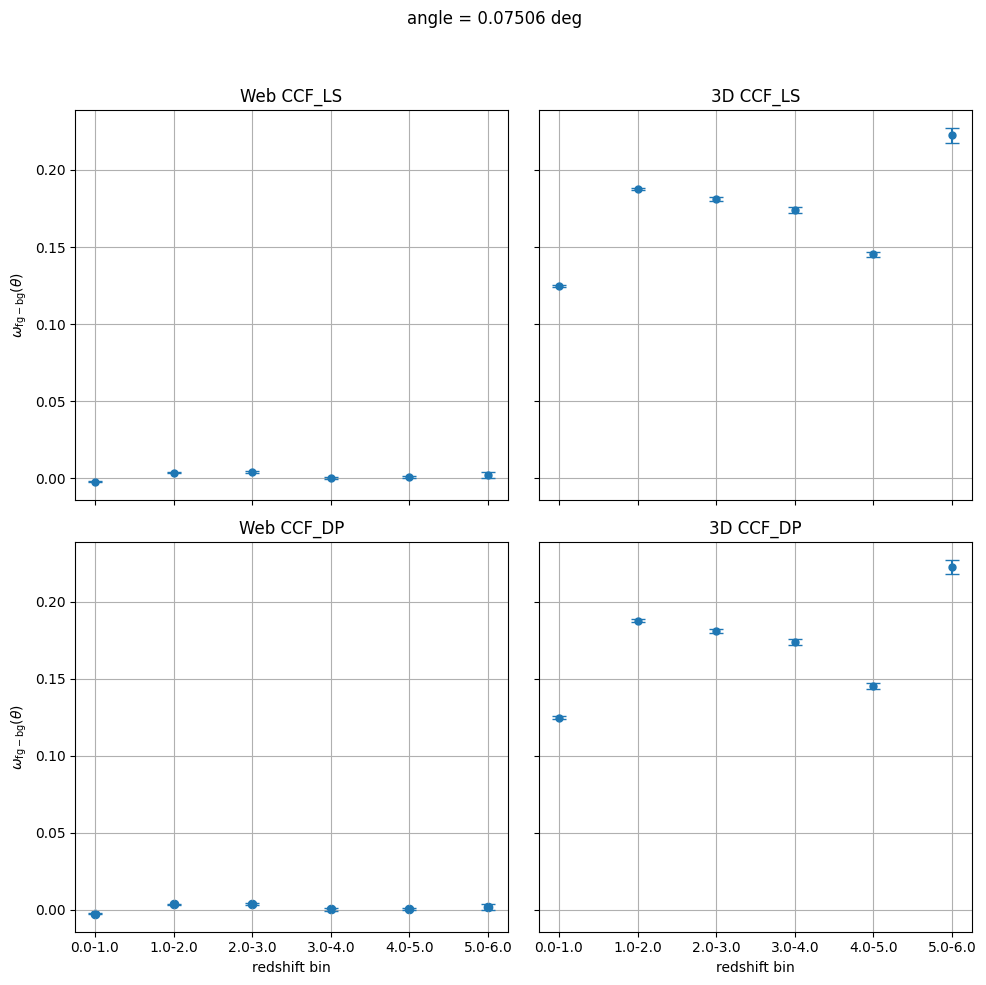

In [20]:
for j in range(len(values_web_DP)):
    fig, axes = plt.subplots(2, 2, figsize=(10,10), sharey=True)
    fig.suptitle(f'angle = {angles[j]:.5f} deg')

    axes[0,0].set_title('Web CCF_LS')
    #axes[0,0].set_xlabel('redshift bin')
    axes[0,0].set_ylabel(r'$\omega_{\rm fg-bg}(\theta)$')
    axes[0,0].errorbar(z_bins, values_web_LS[j],
            yerr=errors_web_LS[j], fmt='.', ms=10,capsize=5, label=z)
    axes[0,0].tick_params(labelbottom=False)
    axes[0,0].grid()

    axes[0,1].set_title('3D CCF_LS')
    #axes[0,1].set_xlabel('redshift bin')
    axes[0,1].errorbar(z_bins, values_3D_LS[j],
            yerr=errors_3D_LS[j], fmt='.', ms=10,capsize=5, label=z)
    axes[0,1].tick_params(labelbottom=False)
    axes[0,1].grid()

    axes[1,0].set_title('Web CCF_DP')
    axes[1,0].set_xlabel('redshift bin')
    axes[1,0].errorbar(z_bins, values_web_DP[j],
            yerr=errors_web_DP[j], fmt='.', ms=10,capsize=5, label=z)
    axes[1,0].set_ylabel(r'$\omega_{\rm fg-bg}(\theta)$')
    axes[1,0].scatter(z_bins, values_web_DP[j])
    axes[1,0].grid()

    axes[1,1].set_title('3D CCF_DP')
    axes[1,1].set_xlabel('redshift bin')
    axes[1,1].errorbar(z_bins, values_3D_DP[j],
            yerr=errors_3D_DP[j], fmt='.', ms=10,capsize=5, label=z)
    axes[1,1].grid()

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for suptitle

In [34]:
# --- helper: compress for each theta-array (you already have this) ---
def compress_theta_mean(wtheta, theta_centers, theta_min=None, theta_max=None):
    th = np.asarray(theta_centers)
    w = np.asarray(wtheta)
    mask = np.ones_like(th, dtype=bool)
    if theta_min is not None: mask &= (th >= theta_min)
    if theta_max is not None: mask &= (th <= theta_max)
    vals = w[mask]
    if len(vals) == 0:
        return np.mean(w)  # fallback
    return np.mean(vals)

# --- safer clustering_nz that accepts arrays and guards against invalid denominators ---
def clustering_nz_array(wsp_arr, wss_arr, wpp_arr, dz=1.0, eps=1e-15, floor_negative=True):
    wsp = np.asarray(wsp_arr, dtype=float)
    wss = np.asarray(wss_arr, dtype=float)
    wpp = np.asarray(wpp_arr, dtype=float)
    dz = np.asarray(dz)
    if dz.ndim == 0:
        dz = np.full(wsp.shape, float(dz))

    # compute denominator but avoid sqrt of negative
    prod = wss * wpp
    # mark invalid where product <= 0 or any is not finite
    invalid = (~np.isfinite(wsp)) | (~np.isfinite(wss)) | (~np.isfinite(wpp)) | (prod <= 0)

    denom = np.sqrt(np.maximum(prod, 0.0)) + eps
    raw = wsp / (dz * denom)

    # set invalid or non-finite raw to zero (you can choose other behaviour)
    raw = np.where(invalid, 0.0, raw)
    raw = np.where(np.isfinite(raw), raw, 0.0)

    # optionally floor small/negative raws to zero if you want non-negative n(z)
    if floor_negative:
        raw = np.where(raw > 0, raw, 0.0)

    norm = np.sum(raw * dz)
    if norm <= 0:
        # nothing positive: return zeros and let caller inspect raw
        nz = np.zeros_like(raw)
    else:
        nz = raw / norm

    return nz, raw

# --- apply to your data ---
#z_bins = ['0.0-1.0','1.0-2.0','2.0-3.0','3.0-4.0','4.0-5.0','5.0-6.0']
theta_edges = np.logspace(-4, -1, 11)      # 10 bins
theta_centers = np.sqrt(theta_edges[:-1] * theta_edges[1:])  # geometric mean
print(theta_centers)

# build arrays of compressed amplitudes per redshift
wsp_web_arr = np.array([compress_theta_mean(Omega_Web['CCF_LS'][z], theta_centers) for z in z_bins])
wsp_3d_arr  = np.array([compress_theta_mean(Omega_3D['CCF_LS'][z],  theta_centers) for z in z_bins])
wss_arr     = np.array([compress_theta_mean(Omega_ref['ACF_LS'][z],  theta_centers) for z in z_bins])

# If your photo ACF (wpp) is global (same for all z), compress once and broadcast:
wpp_val = compress_theta_mean(Omega_Web['ACF_LS'], theta_centers)
wpp_arr = np.full(len(z_bins), wpp_val)

# now call clustering_nz_array once with the full arrays
nz_web, raw_web = clustering_nz_array(wsp_web_arr, wss_arr, wpp_arr, dz=1.0)
nz_3d,  raw_3d  = clustering_nz_array(wsp_3d_arr,  wss_arr, wpp_arr, dz=1.0)

# diagnostics
print("wsp_web_arr:", wsp_web_arr)
print("wsp_3d_arr:",  wsp_3d_arr)
print("wss_arr:",      wss_arr)
print("wpp_val:", wpp_val)
print("raw_web:", raw_web)
print("nz_web:", nz_web)


[0.00014125 0.00028184 0.00056234 0.00112202 0.00223872 0.00446684
 0.00891251 0.01778279 0.03548134 0.07079458]
wsp_web_arr: [-0.01441104  0.12709521  0.02682145 -0.0056191  -0.00159803  0.12486947]
wsp_3d_arr: [ 0.06250748  0.11743775  0.19651958 -0.06036942 -0.15032785 -0.12152161]
wss_arr: [-4.44589289e-05  7.13914650e-02  2.50954616e-01  3.93794711e-01
  4.39006776e-01  8.21570927e-01]
wpp_val: 1.6818890685131904
raw_web: [0.         0.36678145 0.04128439 0.         0.         0.10622704]
nz_web: [0.         0.71317621 0.08027409 0.         0.         0.20654969]


In [24]:
z_edges = np.array([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0])
z_centers = 0.5 * (z_edges[:-1] + z_edges[1:])   # midpoints
dz = np.diff(z_edges)  # here all = 1.0

print(dz)

[1. 1. 1. 1. 1. 1.]


In [45]:
z_centers

array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5])

Text(0, 0.5, 'n(z) [normalized]')

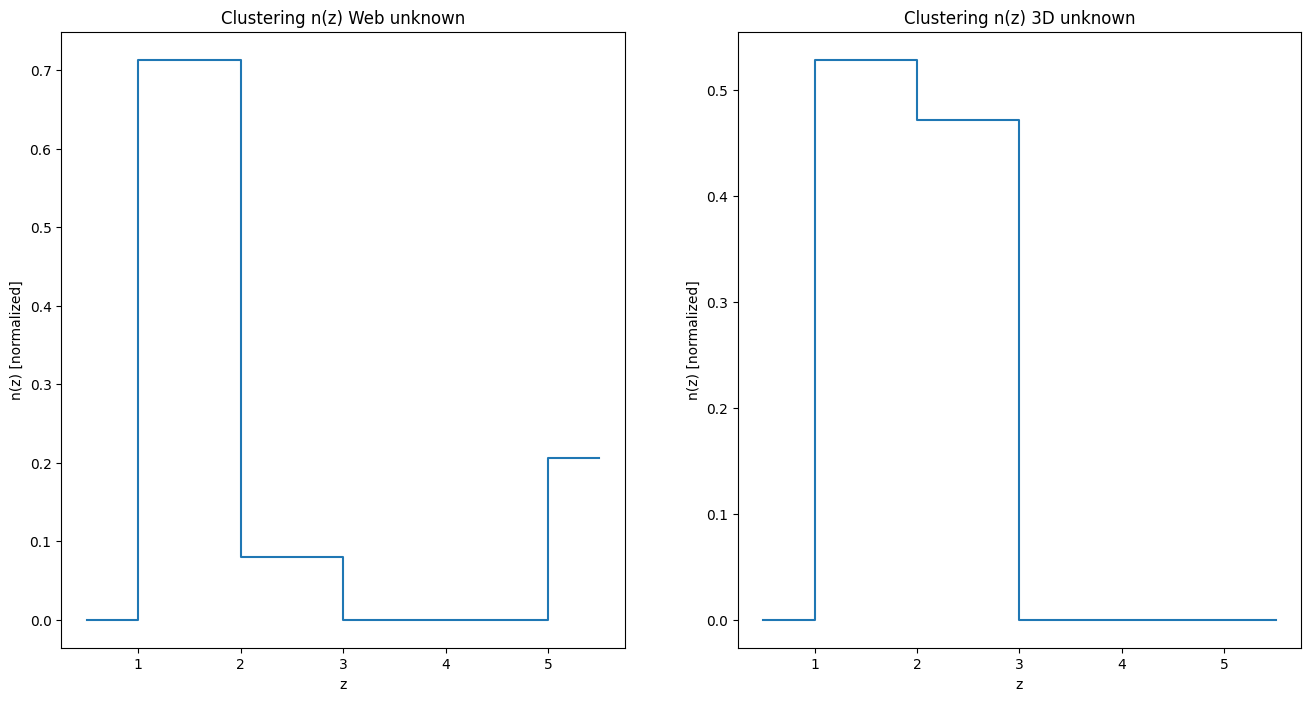

In [ ]:
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.title('Clustering n(z) Web unknown')
plt.step(z_centers, nz_web, where='mid', label='Web unknown')
plt.xlabel('z')
plt.ylabel('n(z) [normalized]')
plt.subplot(1,2,2)
plt.title('Clustering n(z) 3D unknown')
plt.step(z_centers, nz_3d, where='mid', label='3D unknown')
plt.xlabel('z')
plt.ylabel('n(z) [normalized]')

Text(0.5, 0, 'z')

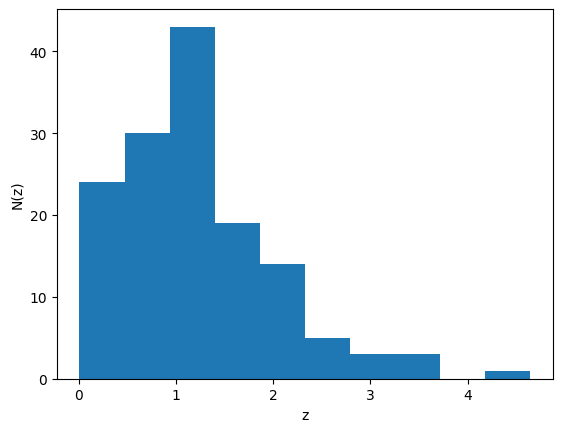

In [ ]:
inferred_z = df_Cos_3D['Host_z']
plt.hist(inferred_z)
plt.ylabel('N(z)')
plt.xlabel('z')